# Import

In [0]:
import pickle
import numpy as np
import os
import tensorflow as tf
from tensorflow.python.framework import tensor_util
import math
import tarfile
import pickle
import random
import numpy as np
import tensorflow as tf
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random

# Preprocessing

In [2]:
from keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

Using TensorFlow backend.


169009152/169001437 [==============================] - 5s 0us/step


In [0]:
cifar100_label = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

In [0]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]
        
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def group_100_classes(x , y):
  """
  This function takes in 60000 pairs of feature and label.
  There are 100 classes in cifar100 with each class having 600 images and labels.
  This function saves 100 training files with each contains 500 training images of one specific class
  100 validation filew with each contains 100 validation images of one specific class
  """
  index_of_validation = 100
  for x in range(0,100):
    features = []
    labels = []
    valid_features = []
    valid_labels = []
    for i in range(0,50000):
      if(y_train[i][0] == x):
        features.append(x_train[i])
        labels.append(y_train[i])
        #delete already stored data
        
    features = np.array(features)
    labels = np.array(labels)
#     print("features:{}".format(features.shape))  
    train_features = features[:-index_of_validation]
#     print('train_features:{}'.format(train_features.shape))
    train_labels = labels[:-index_of_validation]
#     print('train_labels:{}'.format(train_labels.shape))
    valid_features.extend(features[-index_of_validation:])
    valid_labels.extend(labels[-index_of_validation:])
    
    #save files
    _preprocess_and_save(normalize,one_hot_encode,train_features,train_labels,
                        'train'+str(x)+'.p')
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'validation'+str(x)+'.p')
    
def get_5_random_classes():
  """
  This function returns data from five randomly chosen classes 
  as well as validation dataset
  """
  class_list = random.sample(range(0,100),5)
  print(class_list)
  label = []
  for i in class_list:
    label.append(cifar100_label[i])
  print(label)
  features = []
  labels = []
  valid_x = []
  valid_y = []
  for i in class_list:
      filename = 'train' + str(i) + '.p'
      feature1,label1 = pickle.load(open(filename, mode='rb'))
#       print('feature size :{}'.format(feature1.shape))
      filename = 'validation' + str(i) + '.p'
      valid_x1, valid_y1 = pickle.load(open(filename, mode='rb'))
      features.extend(feature1)
      labels.extend(label1)
      valid_x.extend(valid_x1)
      valid_y.extend(valid_y1)
  features = np.array(features)
  labels = np.array(labels)
  
  
  
  return np.array(valid_x), np.array(valid_y), np.array(features), np.array(labels)
      

In [0]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 100))

    for idx, val in enumerate(x):
        encoded[idx][val] = 1

    return encoded
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

# CNN

In [0]:

def Batch_normalization(x,gamma,beta):
  mu = np.mean (x, axis=0)
  var = np.var (x, axis=0)
  x_bar = (x - mu) / np.sqrt(var + 1e-8)
  out = gamma * x_bar + beta
  
  return out
# unfinished

def activation(x):
  # 3 types of activations
  #return tf.nn.sigmoid(x)
  #return tf.nn.tanh(x)
  return tf.nn.relu(x)

def fully_con(tensor,outputsize):
  # Weights and bias
    initializer=tf.contrib.layers.xavier_initializer()
  #  W = tf.Variable(tf.truncated_normal([int(tensor.shape[1]), outputsize], stddev=.05))
    #W = tf.Variable(tf.zeros([int(tensor.shape[1]),outputsize]))
    W = tf.Variable(initializer(shape=[int(tensor.shape[1]),outputsize]))
    b = tf.Variable(tf.zeros([outputsize]))
    x = tf.add(tf.matmul(tensor, W), b)
   
    return activation(x)

def output(tensor, outputsize):
  
  W = tf.Variable(tf.truncated_normal([int(tensor.shape[1]),outputsize],stddev=.05))
  b = tf.Variable(tf.zeros([outputsize]))
  
  return tf.add(tf.matmul(tensor,W),b)




In [0]:
def conv_net(x,keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))
    # 2. Zeros
#     conv1_filter = tf.Variable(tf.zeros([3, 3, 3, 64])) 
#     conv2_filter = tf.Variable(tf.zeros([3, 3, 64, 128])) 
#     conv3_filter = tf.Variable(tf.zeros([5, 5, 128, 256])) 
#     conv4_filter = tf.Variable(tf.zeros([5, 5, 256, 512])) 
  
#     # 3. Xavier
   # initializer=tf.contrib.layers.xavier_initializer()
#     conv1_filter = tf.Variable(initializer(shape=[3, 3, 3, 64]))
#     conv2_filter = tf.Variable(initializer(shape=[3, 3, 64, 128]))                 
#     conv3_filter = tf.Variable(initializer(shape=[5, 5, 128, 256]))
#     conv4_filter = tf.Variable(initializer(shape=[5, 5, 256, 512]))

    biases = {
      #bias for kernels
        
      #random_normal biases
      'r1': tf.Variable(tf.truncated_normal([64],mean=0,stddev=0.08)),
      'r2': tf.Variable(tf.truncated_normal([128],mean=0,stddev=0.08)),
      'r3': tf.Variable(tf.truncated_normal([256],mean=0,stddev=0.08)),
      'r4': tf.Variable(tf.truncated_normal([512],mean=0,stddev=0.08)),
     
      #zeros biases
      'z1': tf.Variable(tf.zeros([64])),
      'z2': tf.Variable(tf.zeros([128])),
      'z3': tf.Variable(tf.zeros([256])),
      'z4': tf.Variable(tf.zeros([512])),
      
#       #Xavier biases
#       'x1': tf.Variable(initializer([64])),
#       'x2': tf.Variable(initializer([128])),
#       'x3': tf.Variable(initializer([256])),
#       'x4': tf.Variable(initializer([512]))
    }
   
    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.bias_add(conv1,biases['z1'])
    conv1 = activation(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1 = tf.layers.batch_normalization(conv1)
    print('shape  of CNN')
    print('conv1:{}'.format(conv1.shape))
    # 3, 4
    conv2 = tf.nn.conv2d(conv1, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.bias_add(conv2,biases['z2'])
    conv2 = activation(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2 = tf.layers.batch_normalization(conv2)
    print('conv2:{}'.format(conv2.shape))
   
   
    # 9
    flat = tf.contrib.layers.flatten(conv2)  
    print('flat layer:{}'.format(flat.shape))
    full1 = fully_con(flat,256)
    full1 = tf.nn.dropout(full1, keep_prob)
    print('fully connected layer:{}'.format(full1.shape))
    full2 = fully_con(full1,512)
    full2 = tf.nn.dropout(full1, keep_prob)
    
    full3 = fully_con(full2,1024)
    full3 = tf.nn.dropout(full1, keep_prob)
    
    #out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    out = output(full1,100)
    print('output layer:{}'.format(out.shape))
    return out

# Training

In [0]:
"""
hyperparameters
"""
epochs = 100
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

In [0]:
group_100_classes(x_train,y_train)

In [12]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()
# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y = tf.placeholder(tf.float32, shape=(None, 100), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

logits = conv_net(x, keep_prob)
model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
optimizer = tf.train.MomentumOptimizer(learning_rate,0.9).minimize(cost)                                              

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

shape  of CNN
conv1:(?, 16, 16, 64)
conv2:(?, 8, 8, 128)
flat layer:(?, 8192)
fully connected layer:(?, 256)
output layer:(?, 100)


In [0]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })
    
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    T_loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    V_loss = sess.run(cost, 
                    feed_dict={
                        x: valid_x,
                        y: valid_y,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_x,
                             y: valid_y,
                             keep_prob: 1.
                         })
    train_acc = sess.run(accuracy, 
                         feed_dict={
                             x: feature_batch,
                             y: label_batch,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(T_loss, valid_acc))
    return T_loss, V_loss, train_acc, valid_acc

In [15]:
save_model_path = './image_classification'
valid_x, valid_y, features, labels = get_5_random_classes()
# print(valid_y)
print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    # Training cycle
    
    
   
    for epoch in range(epochs):
            # Loop over all batches
            for batch_features, batch_labels in batch_features_labels(features, labels, batch_size):
#                 print("\\:{}".format(batch_features.shape))
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2} '.format(epoch + 1), end='')
            
            T_loss, V_loss, train_acc, valid_acc = print_stats(sess, batch_features, batch_labels, cost, accuracy)
            train_losses.append(T_loss)
            valid_losses.append(V_loss)
            train_accs.append(train_acc)
            valid_accs.append(valid_acc)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

[39, 22, 38, 64, 63]
['keyboard', 'clock', 'kangaroo', 'possum', 'porcupine']
Training...
Epoch  1 Loss:     3.9845 Validation Accuracy: 0.278000
Epoch  2 Loss:     1.7352 Validation Accuracy: 0.200000
Epoch  3 Loss:     3.2788 Validation Accuracy: 0.200000
Epoch  4 Loss:     2.4092 Validation Accuracy: 0.202000
Epoch  5 Loss:     1.6548 Validation Accuracy: 0.280000
Epoch  6 Loss:     2.0477 Validation Accuracy: 0.210000
Epoch  7 Loss:     1.7114 Validation Accuracy: 0.246000
Epoch  8 Loss:     1.8544 Validation Accuracy: 0.230000
Epoch  9 Loss:     1.7320 Validation Accuracy: 0.348000
Epoch 10 Loss:     1.7643 Validation Accuracy: 0.316000
Epoch 11 Loss:     1.7302 Validation Accuracy: 0.352000
Epoch 12 Loss:     1.7369 Validation Accuracy: 0.342000
Epoch 13 Loss:     1.6973 Validation Accuracy: 0.344000
Epoch 14 Loss:     1.7009 Validation Accuracy: 0.354000
Epoch 15 Loss:     1.6915 Validation Accuracy: 0.340000
Epoch 16 Loss:     1.6831 Validation Accuracy: 0.346000
Epoch 17 Loss:

#Visualization

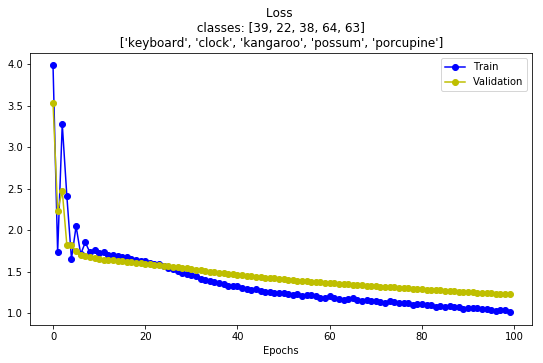

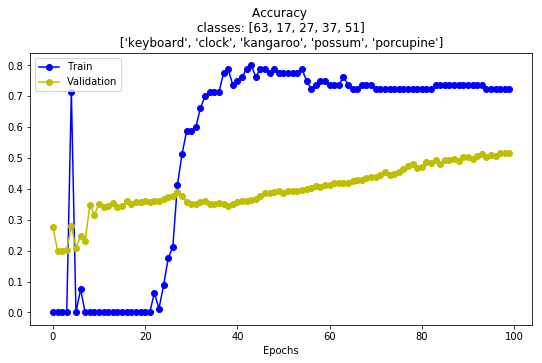

In [16]:
# Plot training curve
    plt.figure(figsize=(9, 5))
    plt.plot(train_losses, 'bo-', label="Train")
    plt.plot(valid_losses, 'yo-', label="Validation")
    plt.legend()
    plt.title("Loss \n classes: [39, 22, 38, 64, 63] \n ['keyboard', 'clock', 'kangaroo', 'possum', 'porcupine'] ")
    plt.xlabel("Epochs")
    plt.show()
    plt.close()
    
    plt.figure(figsize=(9, 5))
    plt.plot(train_accs, 'bo-',label="Train")
    plt.plot(valid_accs, 'yo-',label="Validation")
    plt.legend()
    plt.title("Accuracy \n classes: [63, 17, 27, 37, 51] \n ['keyboard', 'clock', 'kangaroo', 'possum', 'porcupine'] ")
    plt.xlabel("Epochs")
    plt.show()
    plt.close()
    
    